In [1]:
# imports
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cv2
import os
from six.moves import cPickle as pickle
import numpy as np
import matplotlib.image as mpimg

%matplotlib inline

In [2]:
# Augmented data save path
path = 'datasets/traffic-signs-augmented-data'
### path_test = 'traffic-signs-augmented-data-test' # for testing, free to delete.
# mkdir
if not os.path.exists(path):
    os.makedirs(path)

In [3]:
# Image transformation
def affine_transform(img, ang_max, shear_max, trans_max):
    '''
    Apply random affine transformations on an image.
    
    Args:
        img: 1 image array with 3 channels.
        ang_max: integer value to represent max and min values for random
                 angle rotations.
        shear_max: integer value to represent max and min values for random
                   sheering.
        trans_max: integer value to represent max and min values for random
                   translation.
    
    '''
    
    rows = img.shape[0]
    cols = img.shape[1]
    
    # rotation
    rot = np.random.uniform(ang_max) - ang_max / 2
    rot_matrix = cv2.getRotationMatrix2D((cols / 2, rows / 2), rot , 1)

    # shearing
    pts1 = np.float32([[ 10, 10], [20, 10], [10, 20]])
    pt1 = 10 + shear_max * np.random.uniform() - shear_max / 2
    pt2 = 20 + shear_max * np.random.uniform() - shear_max / 2
    pts2 = np.float32([[pt1, 10], [pt2, pt1], [10, pt2]])
    shear_matrix = cv2.getAffineTransform(pts1, pts2)
    
    # translation
    trans_x = trans_max * np.random.uniform() - trans_max / 2
    trans_y = trans_max * np.random.uniform() - trans_max / 2
    trans_matrix = np.float32([[1 , 0, trans_x], [0 , 1, trans_y]])
    
    # affine transformations
    img = cv2.warpAffine(img, rot_matrix,(cols, rows))
    img = cv2.warpAffine(img, trans_matrix,(cols, rows))
    img = cv2.warpAffine(img, shear_matrix,(cols, rows))
    
    return img

In [4]:
# import datasets
training_file = 'datasets/traffic-signs-data/train.p'
validation_file='datasets/traffic-signs-data/valid.p'
testing_file = 'datasets/traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']


def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels

# Randomize datasets
np.random.seed(18361)
X_train, y_train = randomize(X_train, y_train)
X_valid, y_valid = randomize(X_valid, y_valid)
X_test, y_test = randomize(X_test, y_test)

random 3 images:


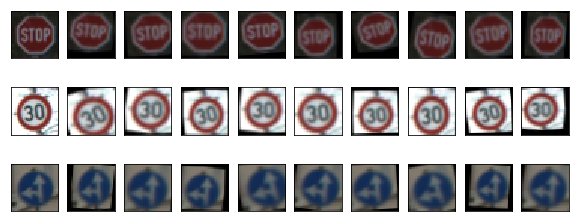

first 3 images:


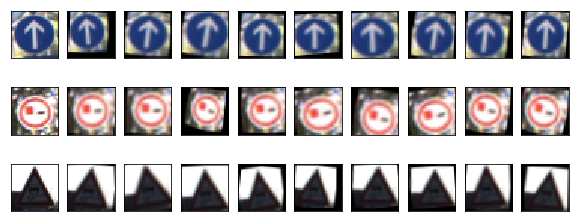

In [5]:
# Test on images

print('random 3 images:')
n_rows = 3
n_cols = 10
fig, axarr = plt.subplots(n_rows, n_cols,
                          figsize=(n_cols, n_rows * (4/3)),
                          subplot_kw={'xticks': [], 'yticks': []})
for i in range(0,3):
    i_img = np.random.randint(X_train.shape[0])
    img = X_train[i_img]
    axarr[i, 0].imshow(img)
    for j in range(1, n_cols):
        trans_img = affine_transform(img, 30, 2, 5)
        axarr[i, j].imshow(trans_img)
plt.show()
plt.close()

print('first 3 images:')

n_rows = 3
n_cols = 10
fig, axarr = plt.subplots(n_rows, n_cols,
                          figsize=(n_cols, n_rows * (4/3)),
                          subplot_kw={'xticks': [], 'yticks': []})

for i in range(0,3):
    img = X_train[i]
    axarr[i, 0].imshow(img)
    for j in range(1, n_cols):
        trans_img = affine_transform(img, 30, 2, 5)
        axarr[i, j].imshow(trans_img)
plt.show()
plt.close()

In [6]:
# Augment all the samples and save

def augment_dataset(X, Y, n_aug, ang_max, shear_max, trans_max):
    """This function augments a dataset.
    
    Takes `X` as the features and `Y` as the labels and
    generates `n_aug` number of transformed images for each sample
    in that dataset.
    
    Arguments:
        X: Numpy array as features of all samples
        Y: Numpy array as labels of all samples
        n_aug: An integer to represent the number of transformed
               images that will be generated.
        ang_max: An integer to represent the angle range.
        shear_max: An integer to represent the shear range.
        trans_max: An integer to represent the transformation range.
    """
    n_samples = Y.shape[0]
    X_aug = np.zeros((n_aug * X.shape[0], X.shape[1], X.shape[2], X.shape[3])
                    , dtype=np.uint8)
    Y_aug = np.zeros((n_aug * Y.shape[0]), dtype=np.uint8)
    i_aug = 0
    for i in range(0, n_samples):
        img = X[i]
        y = Y[i]
        for j in range(0, n_aug):
            trans_img = affine_transform(img, ang_max, shear_max, trans_max)
            X_aug[i_aug, :, :, :] = trans_img
            Y_aug[i_aug] = y
            i_aug += 1
    data_X = np.concatenate((X, X_aug), axis=0)
    data_Y = np.concatenate((Y, Y_aug), axis=0)
    # randomize dataset
    data_X, data_Y = randomize(data_X, data_Y)
    return data_X, data_Y

aug_X_train, aug_Y_train = augment_dataset(X_train, y_train, 5, 30, 2, 5)
aug_X_valid, aug_Y_valid = augment_dataset(X_valid, y_valid, 5, 30, 2, 5)


In [7]:
# save augmented datasets 
# (do not randomize dataset: in the funciton `augment_dataset`,
# comment out the line below `randomize dataset`)
data_train, data_valid = {}, {}
data_train['features'], data_train['labels'] = aug_X_train, aug_Y_train
data_valid['features'], data_valid['labels'] = aug_X_valid, aug_Y_valid

with open(path + '/train.p', mode='wb') as f:
    pickle.dump(data_train, f)
with open(path + '/valid.p', mode='wb') as f:
    pickle.dump(data_valid, f)
    
    
# save for testing

### train, valid = {}, {}
### train['features'], train['labels'] = X_train, y_train
### valid['features'], valid['labels'] = X_valid, y_valid   
    
    
### with open(path_test + '/train1.p', mode='wb') as f:
###     pickle.dump(train, f)
### with open(path_test + '/valid1.p', mode='wb') as f:
###     pickle.dump(valid, f)
    
### with open(path_test + '/train_aug.p', mode='wb') as f:
###     pickle.dump(data_train, f)
### with open(path_test + '/valid_aug.p', mode='wb') as f:
###     pickle.dump(data_valid, f)

#### Stop here or run some test (optional)

In [8]:
# run tests and let's see if anything wrong.
# to have these datasets uncomment the lines
# where starts with `###` above sections.

with open('traffic-signs-augmented-data-test/train_aug.p', 'rb') as f:
    train_aug = pickle.load(f)
with open('traffic-signs-augmented-data-test/valid_aug.p', 'rb') as f:
    valid_aug = pickle.load(f)
with open('traffic-signs-augmented-data-test/train1.p', 'rb') as f:
    train = pickle.load(f)
with open('traffic-signs-augmented-data-test/valid1.p', 'rb') as f:
    valid = pickle.load(f)
    
x_train_aug, y_train_aug = train_aug['features'], train_aug['labels']
x_valid_aug, y_valid_aug = valid_aug['features'], valid_aug['labels']
x_train, y_train = train['features'], train['labels']
x_valid, y_valid = valid['features'], valid['labels']

FileNotFoundError: [Errno 2] No such file or directory: 'traffic-signs-augmented-data-test/train_aug.p'

In [ ]:
print(x_train_aug.shape)
print(x_train.shape)
print(x_train_aug.shape[0] - x_train.shape[0])

In [ ]:
plt.subplot(161)
plt.imshow(x_train[0])
plt.subplot(162)
plt.imshow(x_train_aug[34799])
plt.subplot(163)
plt.imshow(x_train_aug[34800])
plt.subplot(164)
plt.imshow(x_train_aug[34801])
plt.subplot(165)
plt.imshow(x_train_aug[34802])
plt.subplot(166)
plt.imshow(x_train_aug[34803])
plt.show()
plt.close()
plt.subplot(161)
plt.imshow(x_train[1])
plt.subplot(162)
plt.imshow(x_train_aug[34804])
plt.subplot(163)
plt.imshow(x_train_aug[34805])
plt.subplot(164)
plt.imshow(x_train_aug[34806])
plt.subplot(165)
plt.imshow(x_train_aug[34807])
plt.subplot(166)
plt.imshow(x_train_aug[34808])
plt.show()
plt.close()
plt.subplot(161)
plt.imshow(x_train[2])
plt.subplot(162)
plt.imshow(x_train_aug[34809])
plt.subplot(163)
plt.imshow(x_train_aug[34810])
plt.subplot(164)
plt.imshow(x_train_aug[34811])
plt.subplot(165)
plt.imshow(x_train_aug[34812])
plt.subplot(166)
plt.imshow(x_train_aug[34813])
plt.show()
plt.close()